# Submission 1, ML Assignment 1

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.externals import joblib
%matplotlib inline

In [2]:
class BinaryClassificationPerformance():
    '''Performance measures to evaluate the fit of a binary classification model'''
    
    def __init__(self, predictions, labels, desc, probabilities=None):
        '''Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y'''
        '''probabilities-optional, probability that Y is equal to True'''
        self.probabilities = probabilities
        self.performance_df = pd.concat([pd.DataFrame(predictions), pd.DataFrame(labels)], axis=1)
        self.performance_df.columns = ['preds', 'labls']
        self.desc = desc
        self.performance_measures = {}
  
    def compute_measures(self):
        '''Compute performance measures defined by Flach p. 57'''
        self.performance_measures['Pos'] = self.performance_df['preds'].sum()
        self.performance_measures['Neg'] = self.performance_df.shape[0] - self.performance_df['preds'].sum()
        self.performance_measures['TP'] = ((self.performance_df['preds'] == True) & (self.performance_df['labls'] == True)).sum()
        self.performance_measures['TN'] = ((self.performance_df['preds'] == False) & (self.performance_df['labls'] == False)).sum()
        self.performance_measures['FP'] = ((self.performance_df['preds'] == True) & (self.performance_df['labls'] == False)).sum()
        self.performance_measures['FN'] = ((self.performance_df['preds'] == False) & (self.performance_df['labls'] == True)).sum()
        self.performance_measures['Accuracy'] = (self.performance_measures['TP'] + self.performance_measures['TN']) / (self.performance_measures['Pos'] + self.performance_measures['Neg'])

### Read raw test data

In [3]:
amazon = pd.read_csv('/Users/Aaron_hill/Dropbox/data/week06/raw_data_test.csv')
# amazon = pd.read_csv('/Users/aaron/Dropbox/data/week06/raw_data_train.csv')
print(amazon.shape)

(91000, 14)


In [4]:
print(amazon.head())
print(amazon['helpful'].mean())

   Unnamed: 0  Unnamed: 0.1      Id   ProductId          UserId  \
0      400196        411245  411246  B0040WCR6O  A3FFKU2MTCOBM1   
1       38020        110761  110762  B003XUJ3RK   AC2SMT7WEOBQM   
2      366458        192489  192490  B006GA666U  A39FOS1KTT1T8Z   
3       43625        544264  544265  B00125PX8Q  A1XZXAV5OXD08P   
4      211610        494698  494699  B000BZZKVS  A15P774MWM8W4R   

             ProfileName  HelpfulnessNumerator  HelpfulnessDenominator  Score  \
0  new yorker "drealyea"                     0                       0      1   
1                   Bill                     0                       0      5   
2                 kendon                     0                       0      2   
3               Good 4 U                     0                       0      5   
4             D. Dutcher                     8                      11      2   

         Time                            Summary  \
0  1340323200           Overpriced, disapointing   
1  132

### Feature extraction on natural language data

In [ ]:
# # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# from sklearn.feature_extraction.text import CountVectorizer
# vectorizer = CountVectorizer()
# corpus = amazon.Text.as_matrix()
# X_bag_of_words = vectorizer.fit_transform(corpus)
# print(X_bag_of_words.toarray())

In [5]:
# vectorize Bag of Words from review text; as sparse matrix
# from sklearn.feature_extraction.text import HashingVectorizer
# hv = HashingVectorizer(n_features=2 ** 17, non_negative=True)
hv = joblib.load('hv.pkl')
X_hv = hv.transform(amazon.Text)
print(X_hv.shape)

(91000, 131072)


In [6]:
# http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
# from sklearn.feature_extraction.text import TfidfTransformer
# transformer = TfidfTransformer()
transformer = joblib.load('transformer.pkl')
X_tfidf = transformer.transform(X_hv)

In [7]:
print(type(X_tfidf))

<class 'scipy.sparse.csr.csr_matrix'>


### Create additional quantitative features

In [8]:
# features from Amazon.csv to add to feature set
amazon['reviewLen'] = amazon['Text'].str.len()

X_quant_features = amazon[["Score", "reviewLen"]]
print(X_quant_features.head(10))
print(type(X_quant_features))

   Score  reviewLen
0      1        305
1      5        273
2      2        139
3      5        163
4      2        524
5      5        149
6      4        510
7      5        371
8      3        486
9      5        157
<class 'pandas.core.frame.DataFrame'>


### Combine all quantitative features into a single sparse matrix

In [9]:
from scipy.sparse import csr_matrix, hstack
X_quant_features_csr = csr_matrix(X_quant_features)
X_combined = hstack([X_tfidf, X_quant_features_csr])
X_matrix = csr_matrix(X_combined) # convert to sparse matrix
print(X_matrix.shape)

(91000, 131074)


### Create `X`, scaled matrix of features

In [10]:
# feature scaling
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler(with_mean=False)
sc = joblib.load('sc.pkl')
X = sc.fit_transform(X_matrix)
print(X.shape)

(91000, 131074)


### create `y`, vector of Labels

In [11]:
y = amazon['helpful'].values
print(type(y))

<class 'numpy.ndarray'>


### predict `y` with the fit on the training set

In [12]:
# MODEL: Ridge Regression Classifier
# from sklearn import linear_model
# rdg = linear_model.RidgeClassifier()
# rdg.fit(X, y)
# joblib.dump(rdg, 'rdg.pkl') # pickle
rdg = joblib.load('rdg.pkl')

rdg_performance = BinaryClassificationPerformance(rdg.predict(X), y, 'rdg')
rdg_performance.compute_measures()
print(rdg_performance.performance_measures)

{'Pos': 1748, 'FP': 927, 'Accuracy': 0.92614285714285716, 'TN': 83458, 'TP': 821, 'Neg': 89252, 'FN': 5794}


### ROC plot to compare performance of various models and fits

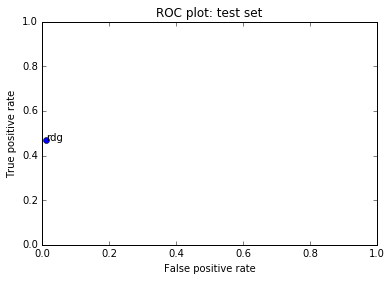

In [14]:
fits = [rdg_performance]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()